In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# data
import numpy as np
np.random.seed(42)

import torch
from torchvision import datasets, transforms

# (1, 28, 28) for CNN
# some people transform it to have 0 mean and 1 std?
class MNISTtrainer(object):
    def __init__(self, batch_size, input_dim=28*28,val_split=0.1):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        train = datasets.MNIST(
                '../data',
                train=True,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ]))

        # split some part of train set to validation
        train_set, val_set = torch.utils.data.random_split(train, [1.-self.val_split, self.val_split])
        self.train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

        self.test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(
                '../data',
                train=False,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)

# (1, 28, 28) for CNN
class FashionMNISTtrainer(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split


        train = datasets.FashionMNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        # split some part of train set to validation
        train_set, val_set = torch.utils.data.random_split(train, [1.-self.val_split, self.val_split])
        self.train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

        self.test_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST(
                '../data',
                train=False,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)

In [3]:
import numpy as np
import torch, random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
###############################random seed##############################################################################
# manualSeed = random.randint(1, 10000) # fix seed
manualSeed = 42
print("Random Seed: ",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
#torch.cuda.manual_seed_all(manualSeed)
# cudnn.benchmark = True
########################################################################################################################


import copy

# init given linear layer m with given sw and sb
def init_weights(m, sw, sb):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0.0, std=(np.sqrt(sw / m.out_features)))
        nn.init.normal_(m.bias, mean=0.0, std=np.sqrt(sb))

# init new model
# TODO: activation function
# TODO: name the layers
def generate_fc_dnn(input_dim, output_dim, params, activation_function=nn.Tanh):
    depth, width = params['depth'], params['width']
    def gen_linear_layer_dim(layer_index):
        return {
            0: (input_dim, width),
            depth - 1: (width, output_dim),
        }.get(layer_index, (width, width))

    fc_list = list()
    for i in range(depth):
        fc_list += [
            nn.Linear(*gen_linear_layer_dim(i)),
            nn.LogSoftmax(dim=1) if (depth - 1 == i) else activation_function()
        ]
    model = nn.Sequential(*fc_list)
    model.apply(lambda m: init_weights(m, params['sw'], params['sb']))
    return model

'''def generate_cnn(input_dim, output_dim, depth, num_channels):
    layers = []
    in_channels = 1  # Assuming grayscale input images

    # Convolutional layers
    for i in range(depth):
        layers.append(nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1))
        layers.append(nn.Tanh())

        # Add MaxPool2d layer every 2 convolutional layers
        if i % 2 == 1:
            layers.append(nn.MaxPool2d(2))
            input_dim = input_dim // 2
            print("input_dim: ", input_dim)

        in_channels = num_channels
        #num_channels *= 2

    # Flatten the output from convolutional layers
    layers.append(nn.Flatten())

    # Fully connected layer for classification
    layers.append(nn.Linear(in_channels * input_dim * input_dim, output_dim))
    layers.append(nn.LogSoftmax(dim=1))

    model = nn.Sequential(*layers)
    return model
'''

class CustomCNN(nn.Module):
    def init(self, input_dim, output_dim, depth, num_channels, act_fn, use_pooling=True):
        super(CustomCNN, self).init()
        in_channels = 1  # Assuming grayscale input images
        conv_count = 0

        self.layers = nn.ModuleList()

        for i in range(depth):
            # Add convolutional layer
            self.layers.append(nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1))
            # Add activation layer
            self.layers.append(act_fn())
            conv_count += 1

            # Add MaxPool2d layer every 2 convolutional layers if use_pooling is set
            if use_pooling and i % 2 == 1:
                self.layers.append(nn.MaxPool2d(2))
                input_dim = input_dim // 2
                print("input_dim: ", input_dim)

            in_channels = num_channels
            # num_channels = 2

        # Add fully connected layer for classification
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_channels, input_dim * input_dim, output_dim)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.flatten(x)
        x = self.fc(x)
        return self.logsoftmax(x)

def generate_cnn(input_dim, output_dim, depth, num_channels, act_fn=nn.ReLU, use_pooling=True):
    model = CustomCNN(input_dim, output_dim, depth, num_channels, act_fn, use_pooling)
    return model

# dataset_loader is fine-tuning dataset
def eval(model, device, dataset_loader, debug):
    model.eval()
    test_loss, correct = 0., 0.
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(
                dim=1,
                keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, num_data, 100. * acc))

    return acc

# TODO: option to freeze some layers
# TODO: option to save the model?
def compute_training_acc(model, dataset, params, debug=False):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    # if debug: print(model, optimizer)

    # run training for few steps and return the accuracy
    train_acc = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(dataset.train_loader):
        data, target = data.reshape([data.shape[0],-1]).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        # Evaluate after every 10 steps epoch
        if debug and batch_idx % 10 == 0:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            print('Step: {} \tTraining Accuracy: {:.2f}%'.format(batch_idx, train_acc*100))
            # if debug and (epoch+1) % 1 == 0:
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('\t\tValidation Accuracy: {:.2f}%'.format(val_acc*100))

    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model

# like previous function, but run for given number of epochs determined by params['num_train']
def compute_training_acc_epochs(model, dataset, params, debug=False):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    # if debug: print(model, optimizer)

    if params['early_stop_patience']:
        no_improve_epochs = 0
        max_val_acc = 0.

    train_acc = 0.0
    model.train()

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                #print('Epoch: {} Train step: {} \tLoss: {:.6f}'.format(epoch, batch_idx, loss.item()))
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            # if debug and (epoch+1) % 1 == 0:
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('Validation Accuracy: {:.2f}%'.format(val_acc*100))

            if params['early_stop_patience']:
                if val_acc > max_val_acc:
                    max_val_acc = val_acc
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1
                    print("val_acc: {}, max_val_acc: {}, no_improve_epochs: {}".format(val_acc, max_val_acc, no_improve_epochs))
                    if no_improve_epochs >= params['early_stop_patience']:
                        print("Early stopping invoked.")
                        break

    # Final evaluation after all epochs are completed
    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model

def eval_cnn(model, device, dataset_loader, debug):
    model.eval()
    test_loss, correct = 0., 0.
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    return acc

def compute_training_acc_epochs_cnn(model, dataset, params, debug=False):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])

    if debug:
        print(model, optimizer)

    train_acc = 0.0
    model.train()

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval_cnn(model, device, dataset.train_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            if debug and (epoch+1) % 3 == 0:
                val_acc = eval_cnn(model, device, dataset.val_loader, debug=False)
                print('Validation Accuracy: {:.2f}%'.format(val_acc*100))

    # Final evaluation after all epochs are completed
    train_acc = eval_cnn(model, device, dataset.train_loader, debug=False)
    test_acc = eval_cnn(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model



# cut_point: no. of layers to keep in the model
# reinitialize after cutting point using init_weights function
def cut_model(model, sw = 1, sb = 1, cut_point=1, freeze=True):
    #deepcopy to avoid changing the original model
    model = copy.deepcopy(model)
    # Convert sequential model to list of layers
    layers = list(model.children())

    # Check if cut_point is out of range
    if cut_point < 0 or cut_point >= len(layers) // 2:
        raise ValueError("cut_point should be in range [0, number of layers - 1]")

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for i in range(cut_point):
            for param in layers[2*i].parameters():
                param.requires_grad = False

    # Cut layers
    new_layers = layers[:2*cut_point]

    # Reinitialize layers after cut point
    for i in range(cut_point, len(layers) // 2):
        linear_layer = layers[2*i]
        activation = layers[2*i + 1]

        # Apply initialization
        init_weights(linear_layer, sw, sb)

        # Append to new layers
        new_layers.extend([linear_layer, activation])

    # Return new model
    return nn.Sequential(*new_layers)

def cut_cnn_model(model, cut_point=1, freeze=True):
    """
    Cut the CNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (nn.Module): Original model.
    - cut_point (int): Layer index at which to cut the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.

    Returns:
    - new_model (nn.Sequential): Cut and potentially modified model.
    """

    # Deep copy to avoid changing the original model
    model = copy.deepcopy(model)

    # Convert sequential model to list of layers
    layers = list(model.children())

    # Check if cut_point is out of range
    if cut_point < 0 or cut_point >= len(layers):
        raise ValueError("cut_point should be in range [0, number of layers - 1]")

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for i in range(cut_point):
            for param in layers[i].parameters():
                param.requires_grad = False

    # Cut layers
    new_layers = layers[:cut_point]

    # Reinitialize layers after cut point
    for i in range(cut_point, len(layers)):
        layer = layers[i]

        # Reinitialize weights if layer has parameters (like Conv2d)
        if hasattr(layer, 'weight'):
            nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

        # Append to new layers
        new_layers.append(layer)

    # Return new model
    return nn.Sequential(*new_layers)

Random Seed:  42


### Baseline, end to end trained model

In [5]:
batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'mps'
depth = 100
width = 300

fashion_dataset = FashionMNISTtrainer(batch_size)

# early stopping? False if not needed, otherwise int
params = dict(device=device,
                width=width, lr=1e-3, num_train=60,
                sb=0.05, depth=depth, sw=2.0, early_stop_patience=10, activation_function='relu')
if params['activation_function'] == 'relu':
    activation_function = nn.ReLU
elif params['activation_function'] == 'tanh':
    activation_function = nn.Tanh
else:
    activation_function = nn.Tanh

fashion_model = generate_fc_dnn(fashion_dataset.input_dim, fashion_dataset.output_dim,
                params, activation_function=activation_function).to(device)

pretrain_acc, pretrain_test_acc, pre_trained_model = compute_training_acc_epochs(fashion_model, fashion_dataset, params, debug=True)
# pretrain_acc, pretrain_test_acc, pre_trained_model = compute_training_acc(fashion_model, fashion_dataset, params, debug=True)


Epoch: 0 	Training Accuracy: 30.39%
Validation Accuracy: 29.80%
Epoch: 1 	Training Accuracy: 43.56%
Validation Accuracy: 43.15%
Epoch: 2 	Training Accuracy: 62.29%
Validation Accuracy: 62.15%
Epoch: 3 	Training Accuracy: 70.94%
Validation Accuracy: 70.77%
Epoch: 4 	Training Accuracy: 73.88%
Validation Accuracy: 72.80%
Epoch: 5 	Training Accuracy: 75.45%
Validation Accuracy: 74.70%
Epoch: 6 	Training Accuracy: 75.91%
Validation Accuracy: 75.02%
Epoch: 7 	Training Accuracy: 76.94%
Validation Accuracy: 76.95%
Epoch: 8 	Training Accuracy: 77.96%
Validation Accuracy: 77.18%
Epoch: 9 	Training Accuracy: 79.63%
Validation Accuracy: 78.87%
Epoch: 10 	Training Accuracy: 79.10%
Validation Accuracy: 78.47%
val_acc: 0.7846666666666666, max_val_acc: 0.7886666666666666, no_improve_epochs: 1
Epoch: 11 	Training Accuracy: 81.07%
Validation Accuracy: 79.35%
Epoch: 12 	Training Accuracy: 81.55%
Validation Accuracy: 80.67%
Epoch: 13 	Training Accuracy: 81.39%
Validation Accuracy: 79.68%
val_acc: 0.796833

In [6]:
# save the model with hyperparams
import json, os

models_path = "drive/MyDrive/MP/models"
if not os.path.exists(models_path):
    os.mkdir(models_path)

# below choose where you name the new directory
model_path = os.path.join(models_path, "fashion_to_mnist_relu_1")
os.mkdir(model_path)
torch.save(fashion_model.state_dict(), os.path.join(model_path, "pretrained_model.pt"))

params['batch_size'] = batch_size
del params['device']
with open(os.path.join(model_path, "model_params.json"), "w+") as f:
      json.dump(params, f, indent=2, ensure_ascii=False)  # encode dict into JSON

In [ ]:
# load the model
import json, os

batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'mps'
depth = 100
width = 300

fashion_dataset = FashionMNISTtrainer(batch_size)

models_path = "drive/MyDrive/MP"
model_path = os.path.join(models_path, "fashion_to_mnist_1")

with open(os.path.join(model_path, "model_params.json"), "r") as f:
    params = json.load(f)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
params['device'] = device
fashion_model = generate_fc_dnn(fashion_dataset.input_dim, fashion_dataset.output_dim, params)
fashion_model.load_state_dict(torch.load(os.path.join(model_path, "pretrained_model.pt")))
fashion_model.to(device)
fashion_model.eval()

100%|██████████| 26421880/26421880 [00:00<00:00, 115373216.48it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5158335.04it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 63549349.03it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18129535.68it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): Tanh()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): Tanh()
  (4): Linear(in_features=300, out_features=300, bias=True)
  (5): Tanh()
  (6): Linear(in_features=300, out_features=300, bias=True)
  (7): Tanh()
  (8): Linear(in_features=300, out_features=300, bias=True)
  (9): Tanh()
  (10): Linear(in_features=300, out_features=300, bias=True)
  (11): Tanh()
  (12): Linear(in_features=300, out_features=300, bias=True)
  (13): Tanh()
  (14): Linear(in_features=300, out_features=300, bias=True)
  (15): Tanh()
  (16): Linear(in_features=300, out_features=300, bias=True)
  (17): Tanh()
  (18): Linear(in_features=300, out_features=300, bias=True)
  (19): Tanh()
  (20): Linear(in_features=300, out_features=300, bias=True)
  (21): Tanh()
  (22): Linear(in_features=300, out_features=300, bias=True)
  (23): Tanh()
  (24): Linear(in_features=300, out_features=300, bias=True)
  (25): Tanh()
  (26): Li

In [ ]:
eval(fashion_model, device, fashion_dataset.train_loader, debug=False)

0.9078888888888889

### finetuned staring from regular mnist

In [8]:
params

{'width': 300,
 'lr': 0.001,
 'num_train': 60,
 'sb': 0.05,
 'depth': 100,
 'sw': 2.0,
 'early_stop_patience': 10,
 'activation_function': 'relu',
 'batch_size': 256}

In [18]:
#luckily, the number of classes is the same, so we don't need to change the last layer.
from tqdm import tqdm

number_dataset = MNISTtrainer(batch_size)

cut_models = []

# epochs fro fine tuning
params['num_train'] = 10
params['early_stop_patience'] = False
params['device'] = device
for cut in tqdm(range(0, depth, 10)):
    temp = {}
    temp['cut_model'] = cut_model(fashion_model, sw = params['sw'], sb = params['sb'], cut_point = cut, freeze=True)
    finetuned_acc, finetuned_test_acc, finetuned_model = compute_training_acc_epochs(temp['cut_model'], number_dataset, params, debug=False)
    temp['finetuned_acc'] = finetuned_acc
    temp['finetuned_test_acc'] = finetuned_test_acc
    temp['finetuned_model'] = finetuned_model
    cut_models.append(temp)
    # save everything - ?

100%|██████████| 10/10 [21:49<00:00, 130.99s/it]


# Froze the Layers

In [19]:
from pprint import pprint

for i, mod in enumerate(cut_models):
    print(f"Cut {i*10}:")
    pprint(mod['finetuned_acc'])

Cut 0:
0.8553703703703703
Cut 10:
0.5964444444444444
Cut 20:
0.45061111111111113
Cut 30:
0.35555555555555557
Cut 40:
0.3450185185185185
Cut 50:
0.3272962962962963
Cut 60:
0.32401851851851854
Cut 70:
0.2945925925925926
Cut 80:
0.2947037037037037
Cut 90:
0.2817222222222222


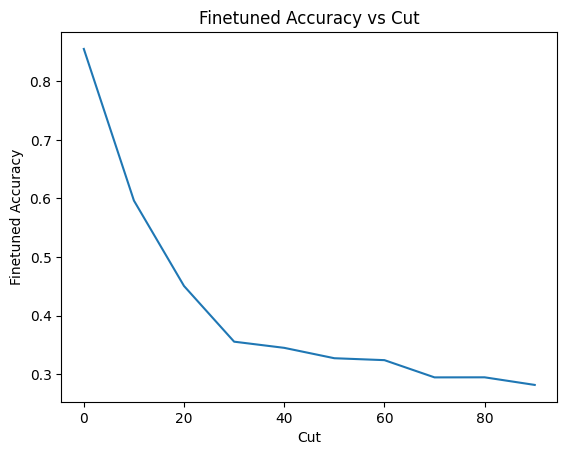

In [20]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_acc'] for model in cut_models]
cuts = range(0,len(finetuned_accs)*10,10)
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Accuracy')
plt.title('Finetuned Accuracy vs Cut')
plt.show()

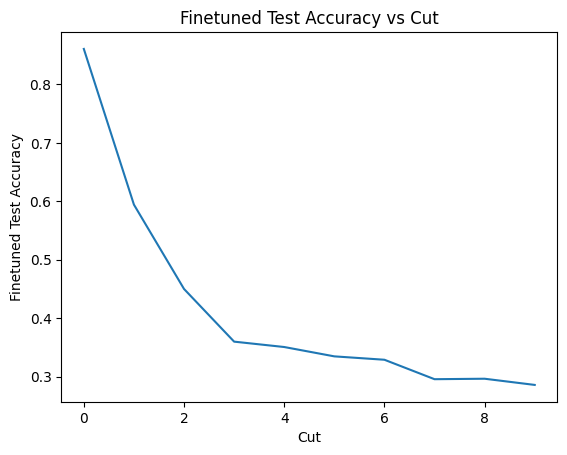

In [21]:
import matplotlib.pyplot as plt

finetuned_test_accs = [model['finetuned_test_acc'] for model in cut_models]
cuts = range(len(finetuned_test_accs))
plt.plot(cuts, finetuned_test_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Test Accuracy')
plt.title('Finetuned Test Accuracy vs Cut')
plt.show()

----

# Variances

Layer linear_0 - Variance: 0.4037374258041382
Layer tanh_0 - Variance: 0.17040479183197021
Layer linear_1 - Variance: 0.3515036702156067
Layer tanh_1 - Variance: 0.16025783121585846
Layer linear_2 - Variance: 0.34120380878448486
Layer tanh_2 - Variance: 0.15781065821647644
Layer linear_3 - Variance: 0.32339030504226685
Layer tanh_3 - Variance: 0.14360472559928894
Layer linear_4 - Variance: 0.3123285472393036
Layer tanh_4 - Variance: 0.1447790116071701
Layer linear_5 - Variance: 0.31801342964172363
Layer tanh_5 - Variance: 0.14296720921993256
Layer linear_6 - Variance: 0.30935049057006836
Layer tanh_6 - Variance: 0.13975833356380463
Layer linear_7 - Variance: 0.3073298931121826
Layer tanh_7 - Variance: 0.1337941288948059
Layer linear_8 - Variance: 0.30121222138404846
Layer tanh_8 - Variance: 0.13037966191768646
Layer linear_9 - Variance: 0.30389878153800964
Layer tanh_9 - Variance: 0.14385265111923218
Layer linear_10 - Variance: 0.32833772897720337
Layer tanh_10 - Variance: 0.1584817469

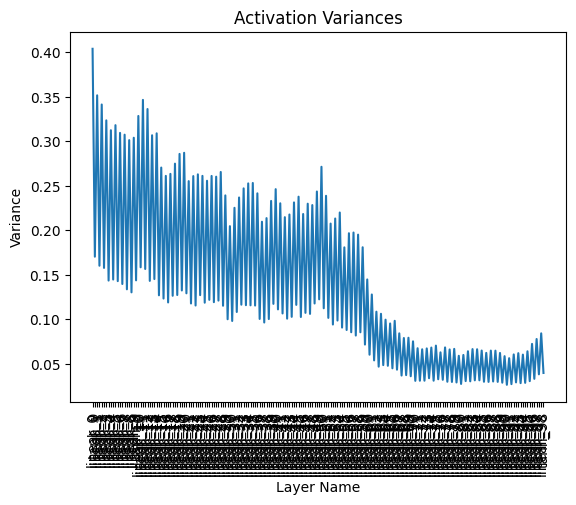

In [22]:
def compute_layer_variances(model, test_loader, device='cpu'):
    # Define a hook to collect activations
    activations = {}

    def create_hook(name):
        def hook(module, input, output):
            activations[name] = output
        return hook

    for i, layer in enumerate(linear_layers):
        layer.register_forward_hook(create_hook("linear_{}".format(i)))

    for i, layer in enumerate(activation_layers):
        layer.register_forward_hook(create_hook("tanh_{}".format(i)))

    # Run inference on the test set
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.reshape([images.shape[0], -1]).to(device)
            outputs = model(images)

    # Calculate and print variance for each layer's activations
    variances = {key: torch.var(act, dim=0) for key, act in activations.items()}

    result = {}
    for layer_name, variance in variances.items():
        result[layer_name] = variance.mean().item()

    return result, variances

# Usage:
linear_layers = []
activation_layers = []
for i, layer in enumerate(fashion_model.modules()):
  if i % 2 == 1:
    linear_layers.append(layer)
  else:
    activation_layers.append(layer)
activation_layers = activation_layers[1:]

results, variances = compute_layer_variances(fashion_model, fashion_dataset.test_loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")

import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], variance_values[:-2])
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()


Layer linear_0 - Variance: 0.43985703587532043
Layer tanh_0 - Variance: 0.18410161137580872
Layer linear_1 - Variance: 0.38652950525283813
Layer tanh_1 - Variance: 0.17786769568920135
Layer linear_2 - Variance: 0.39280110597610474
Layer tanh_2 - Variance: 0.17503079771995544
Layer linear_3 - Variance: 0.36325064301490784
Layer tanh_3 - Variance: 0.16760608553886414
Layer linear_4 - Variance: 0.3584757149219513
Layer tanh_4 - Variance: 0.16448047757148743
Layer linear_5 - Variance: 0.36602962017059326
Layer tanh_5 - Variance: 0.17156574130058289
Layer linear_6 - Variance: 0.357797235250473
Layer tanh_6 - Variance: 0.16030210256576538
Layer linear_7 - Variance: 0.3423413336277008
Layer tanh_7 - Variance: 0.14697863161563873
Layer linear_8 - Variance: 0.32381340861320496
Layer tanh_8 - Variance: 0.1426578015089035
Layer linear_9 - Variance: 0.32027167081832886
Layer tanh_9 - Variance: 0.1499495953321457
Layer linear_10 - Variance: 0.3267512321472168
Layer tanh_10 - Variance: 0.16131141781

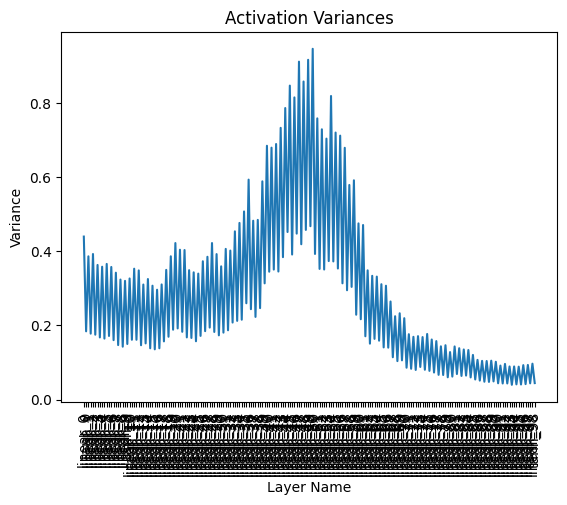

In [23]:
# Same on the train set:
results, variances = compute_layer_variances(fashion_model, fashion_dataset.train_loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")

import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], variance_values[:-2])
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()


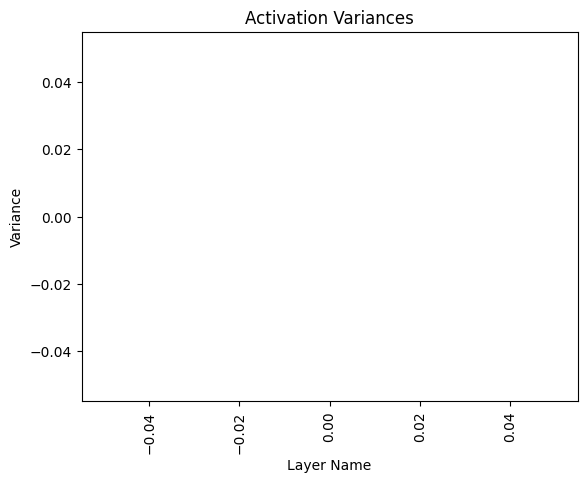

In [25]:
# on the fine-tuning dataset?
results, variances = compute_layer_variances(fashion_model, number_dataset.test_loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], variance_values[:-2])
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()

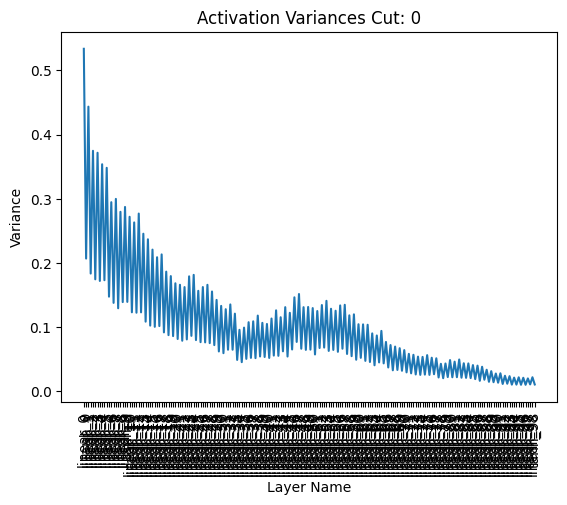

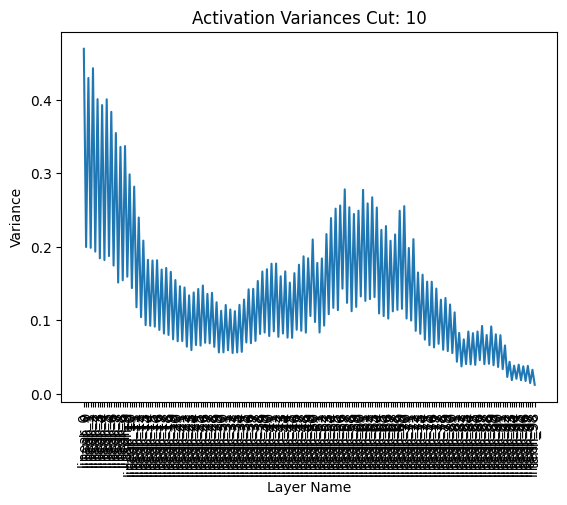

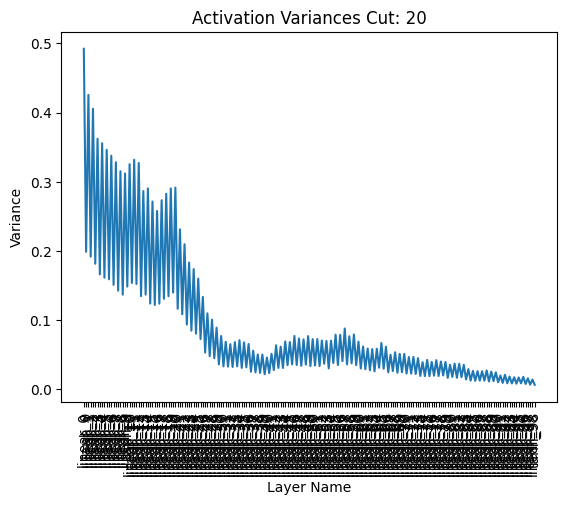

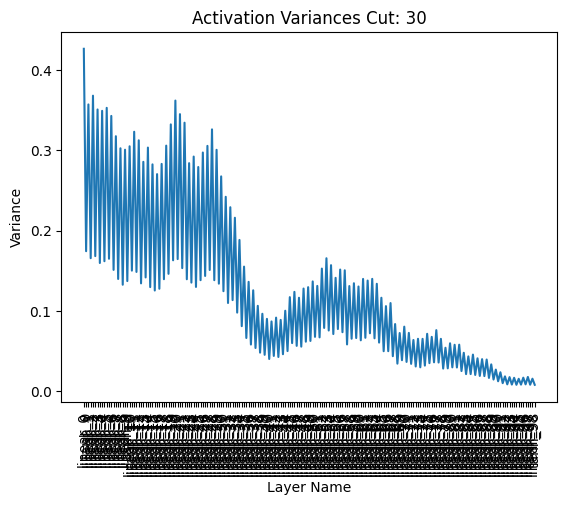

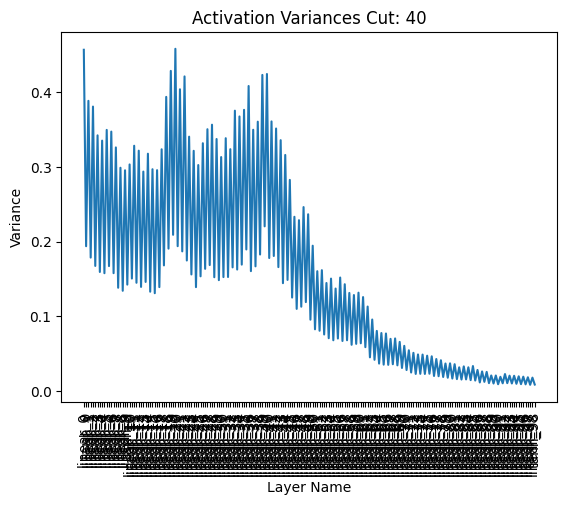

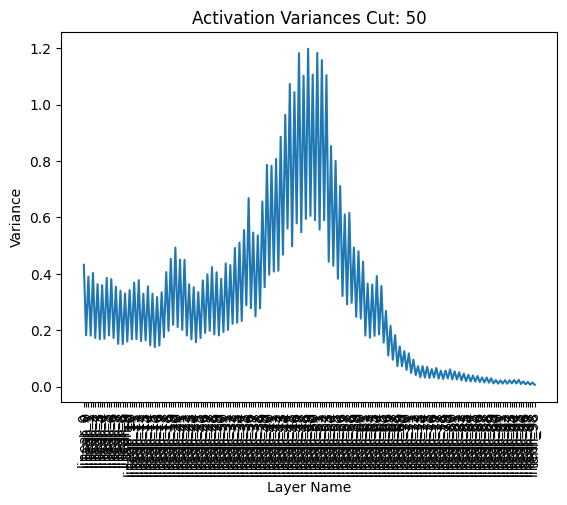

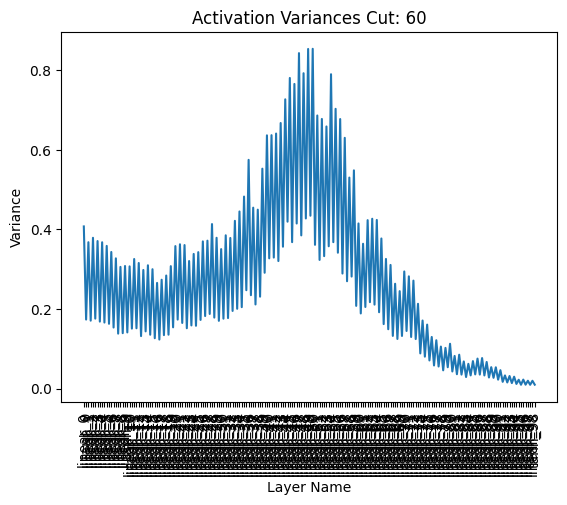

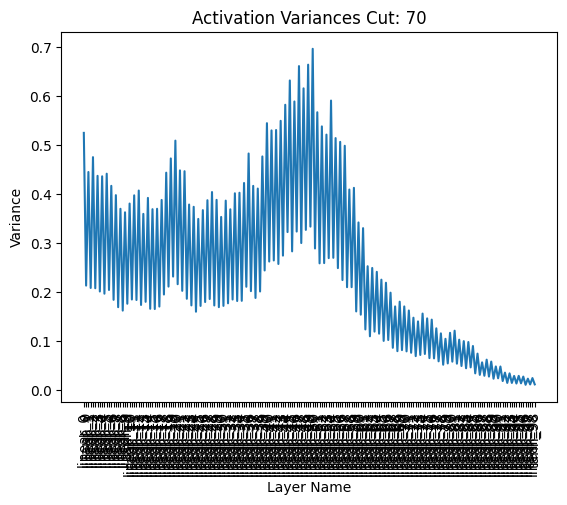

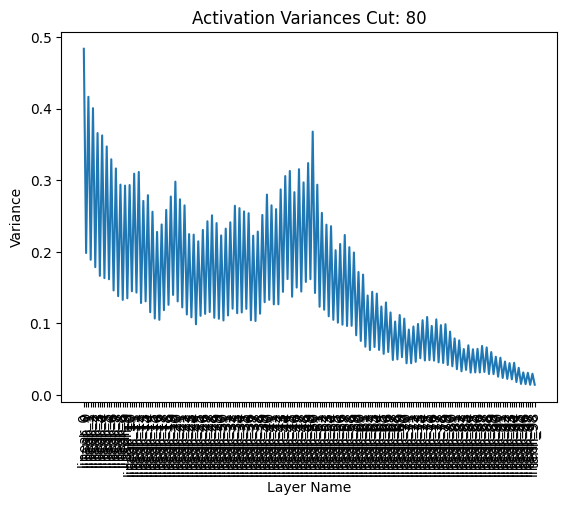

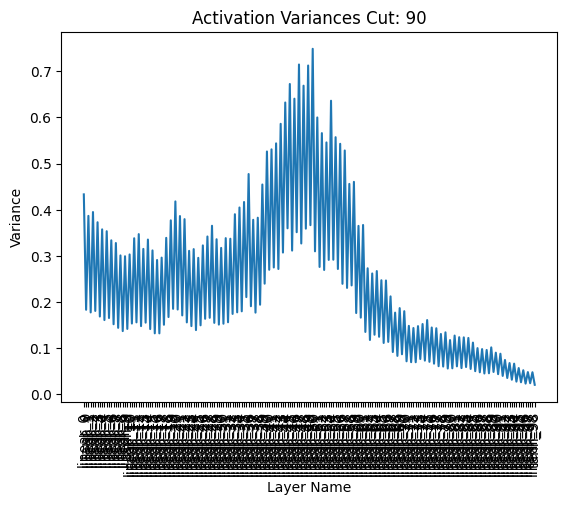

In [24]:
for idx, mod in enumerate(cut_models):
    # Same for all fine-tuned:
    mod['cut_model'].eval()
    linear_layers = []
    activation_layers = []
    for i, layer in enumerate(mod['cut_model'].modules()):
      if i % 2 == 1:
        linear_layers.append(layer)
      else:
        activation_layers.append(layer)
    activation_layers = activation_layers[1:]
    results, variances = compute_layer_variances(mod['cut_model'], fashion_dataset.test_loader, device = 'cuda')
    # for layer_name, variance in results.items():
    #    print(f"Layer {layer_name} - Variance: {variance}")

    # Create a list of layer names and variances
    layer_names = list(variances.keys())
    variance_values = [variance.mean().item() for variance in variances.values()]

    # Plot the variances
    plt.plot(layer_names[:-2], variance_values[:-2])
    plt.xticks(rotation=90)
    plt.xlabel('Layer Name')
    plt.ylabel('Variance')
    plt.title('Activation Variances Cut: {}'.format(idx*10))
    plt.show()

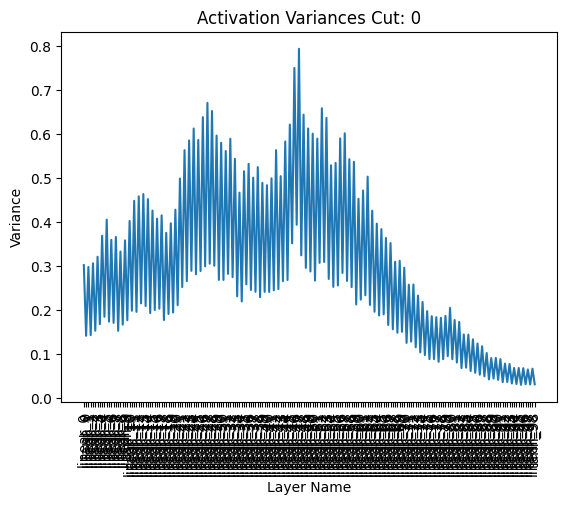

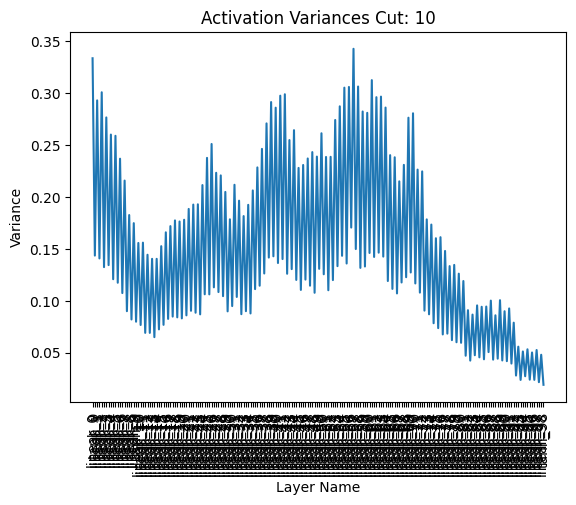

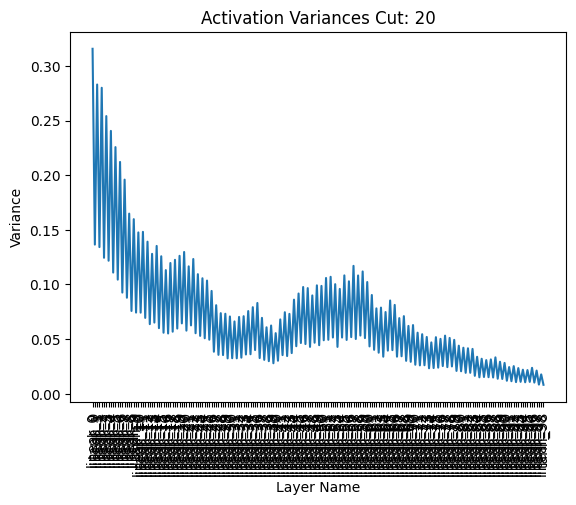

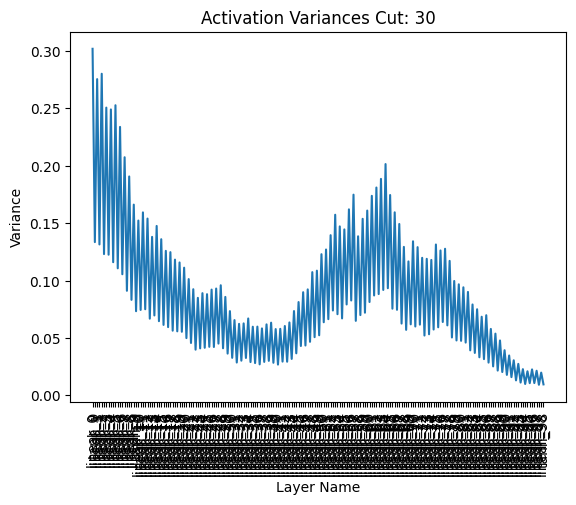

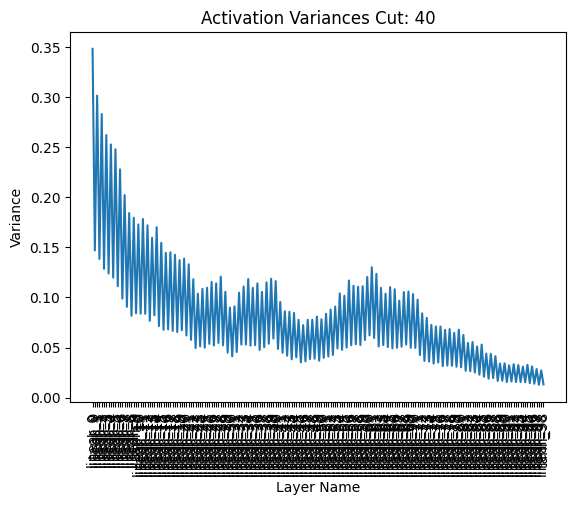

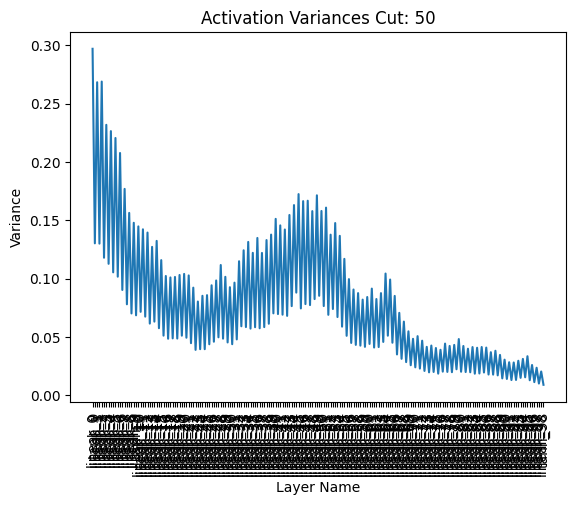

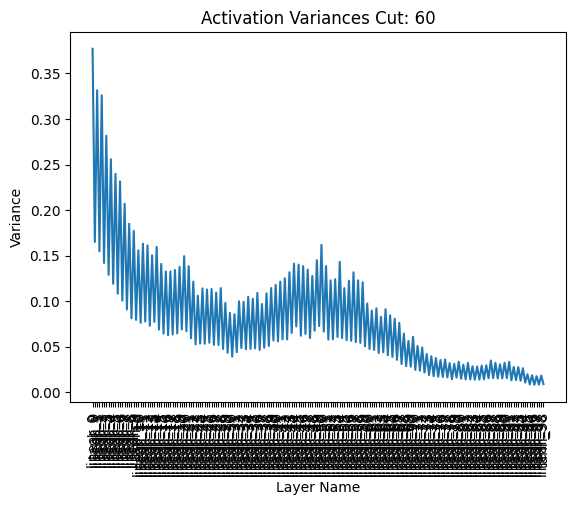

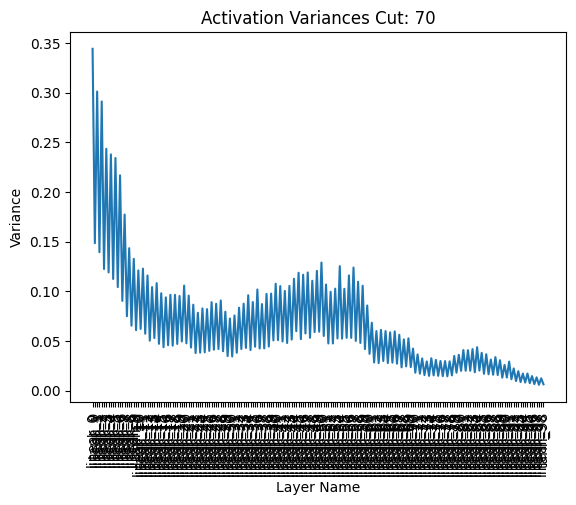

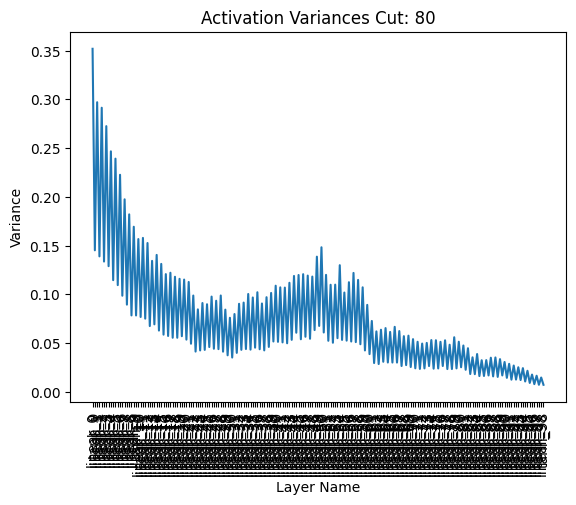

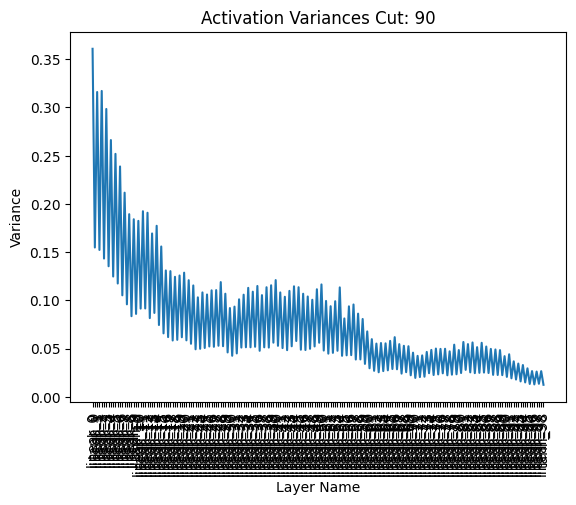

In [26]:
for idx, mod in enumerate(cut_models):
    # Same for all fine-tuned:
    mod['cut_model'].eval()
    linear_layers = []
    activation_layers = []
    for i, layer in enumerate(mod['cut_model'].modules()):
      if i % 2 == 1:
        linear_layers.append(layer)
      else:
        activation_layers.append(layer)
    activation_layers = activation_layers[1:]
    results, variances = compute_layer_variances(mod['cut_model'], number_dataset.test_loader, device = 'cuda')
    # for layer_name, variance in results.items():
    #    print(f"Layer {layer_name} - Variance: {variance}")

    # Create a list of layer names and variances
    layer_names = list(variances.keys())
    variance_values = [variance.mean().item() for variance in variances.values()]

    # Plot the variances
    plt.plot(layer_names[:-2], variance_values[:-2])
    plt.xticks(rotation=90)
    plt.xlabel('Layer Name')
    plt.ylabel('Variance')
    plt.title('Activation Variances Cut: {}'.format(idx*10))
    plt.show()

# Without Freezing the Layers

In [11]:
from pprint import pprint

for i, mod in enumerate(cut_models):
    print(f"Cut {i*10}:")
    pprint(mod['finetuned_acc'])

Cut 0:
0.7629814814814815
Cut 10:
0.8742407407407408
Cut 20:
0.8536111111111111
Cut 30:
0.8928333333333334
Cut 40:
0.8978333333333334
Cut 50:
0.8891851851851852
Cut 60:
0.8732407407407408
Cut 70:
0.9089444444444444
Cut 80:
0.8906851851851851
Cut 90:
0.8716851851851852


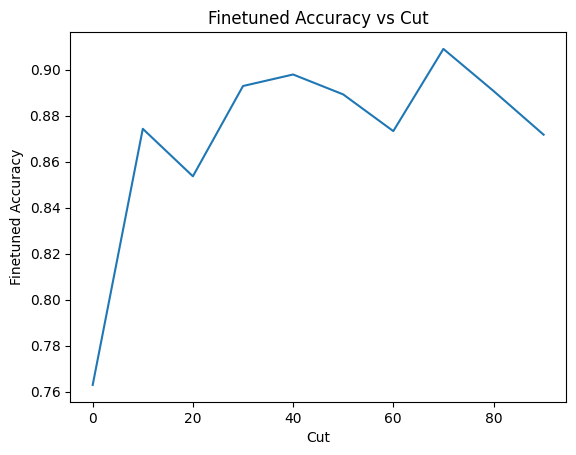

In [12]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_acc'] for model in cut_models]
cuts = range(0,len(finetuned_accs)*10,10)
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Accuracy')
plt.title('Finetuned Accuracy vs Cut')
plt.show()

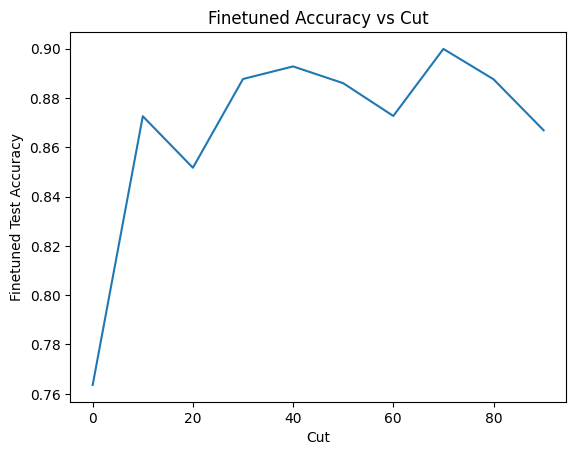

In [13]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_test_acc'] for model in cut_models]
cuts = range(0,len(finetuned_accs)*10,10)
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Test Accuracy')
plt.title('Finetuned Accuracy vs Cut')
plt.show()

# Variances

Layer linear_0 - Variance: 0.45981165766716003
Layer tanh_0 - Variance: 0.19551856815814972
Layer linear_1 - Variance: 0.40029117465019226
Layer tanh_1 - Variance: 0.18101918697357178
Layer linear_2 - Variance: 0.4050746262073517
Layer tanh_2 - Variance: 0.18569543957710266
Layer linear_3 - Variance: 0.3891991674900055
Layer tanh_3 - Variance: 0.18478603661060333
Layer linear_4 - Variance: 0.39539453387260437
Layer tanh_4 - Variance: 0.18417169153690338
Layer linear_5 - Variance: 0.4092276394367218
Layer tanh_5 - Variance: 0.19433332979679108
Layer linear_6 - Variance: 0.40241122245788574
Layer tanh_6 - Variance: 0.18177741765975952
Layer linear_7 - Variance: 0.38142967224121094
Layer tanh_7 - Variance: 0.1608532965183258
Layer linear_8 - Variance: 0.35339850187301636
Layer tanh_8 - Variance: 0.16238896548748016
Layer linear_9 - Variance: 0.3642377555370331
Layer tanh_9 - Variance: 0.17351587116718292
Layer linear_10 - Variance: 0.3758928179740906
Layer tanh_10 - Variance: 0.1878114044

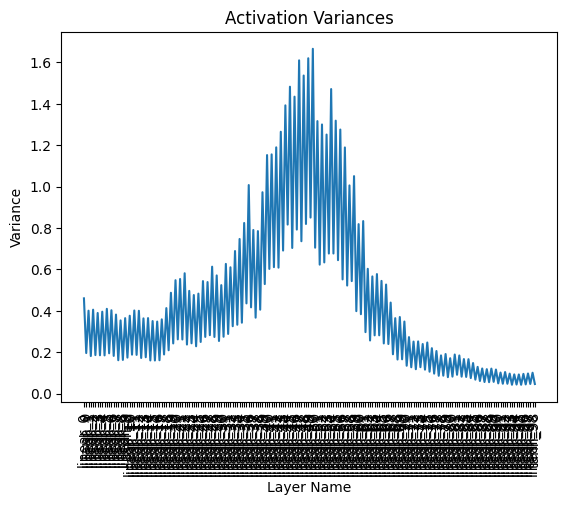

In [14]:
def compute_layer_variances(model, test_loader, device='cpu'):
    # Define a hook to collect activations
    activations = {}

    def create_hook(name):
        def hook(module, input, output):
            activations[name] = output
        return hook

    for i, layer in enumerate(linear_layers):
        layer.register_forward_hook(create_hook("linear_{}".format(i)))

    for i, layer in enumerate(activation_layers):
        layer.register_forward_hook(create_hook("relu_{}".format(i)))

    # Run inference on the test set
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.reshape([images.shape[0], -1]).to(device)
            outputs = model(images)

    # Calculate and print variance for each layer's activations
    variances = {key: torch.var(act, dim=0) for key, act in activations.items()}

    result = {}
    for layer_name, variance in variances.items():
        result[layer_name] = variance.mean().item()

    return result, variances

# Usage:
linear_layers = []
activation_layers = []
for i, layer in enumerate(fashion_model.modules()):
  if i % 2 == 1:
    linear_layers.append(layer)
  else:
    activation_layers.append(layer)
activation_layers = activation_layers[1:]

results, variances = compute_layer_variances(fashion_model, fashion_dataset.test_loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")

import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], variance_values[:-2])
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()


Layer linear_0 - Variance: 0.43519115447998047
Layer tanh_0 - Variance: 0.18409284949302673
Layer linear_1 - Variance: 0.3886111378669739
Layer tanh_1 - Variance: 0.17921783030033112
Layer linear_2 - Variance: 0.39464840292930603
Layer tanh_2 - Variance: 0.17724955081939697
Layer linear_3 - Variance: 0.3679216504096985
Layer tanh_3 - Variance: 0.17020747065544128
Layer linear_4 - Variance: 0.3679491877555847
Layer tanh_4 - Variance: 0.16832226514816284
Layer linear_5 - Variance: 0.3721155822277069
Layer tanh_5 - Variance: 0.17333143949508667
Layer linear_6 - Variance: 0.35782286524772644
Layer tanh_6 - Variance: 0.1617167443037033
Layer linear_7 - Variance: 0.34477025270462036
Layer tanh_7 - Variance: 0.14724522829055786
Layer linear_8 - Variance: 0.3174475431442261
Layer tanh_8 - Variance: 0.14104554057121277
Layer linear_9 - Variance: 0.31199169158935547
Layer tanh_9 - Variance: 0.14651547372341156
Layer linear_10 - Variance: 0.31647711992263794
Layer tanh_10 - Variance: 0.1583382934

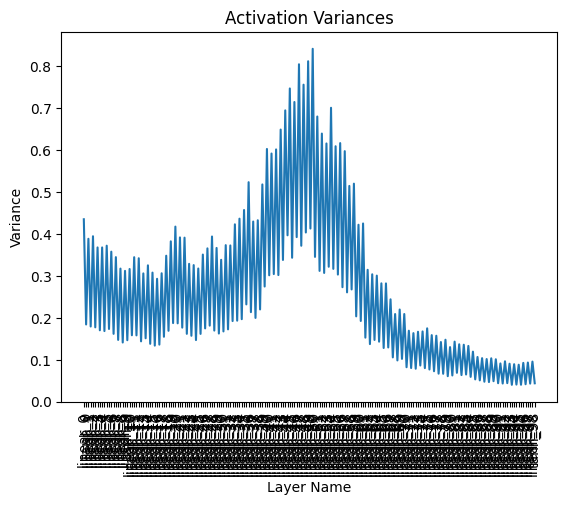

In [15]:
# Same on the train set:
results, variances = compute_layer_variances(fashion_model, fashion_dataset.train_loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")

import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], variance_values[:-2])
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()


Layer linear_0 - Variance: 0.34834226965904236
Layer tanh_0 - Variance: 0.15273499488830566
Layer linear_1 - Variance: 0.30446672439575195
Layer tanh_1 - Variance: 0.14215324819087982
Layer linear_2 - Variance: 0.2878594994544983
Layer tanh_2 - Variance: 0.12886300683021545
Layer linear_3 - Variance: 0.26348504424095154
Layer tanh_3 - Variance: 0.1254372000694275
Layer linear_4 - Variance: 0.2539456784725189
Layer tanh_4 - Variance: 0.11460991203784943
Layer linear_5 - Variance: 0.24213862419128418
Layer tanh_5 - Variance: 0.11048856377601624
Layer linear_6 - Variance: 0.22506368160247803
Layer tanh_6 - Variance: 0.10187920182943344
Layer linear_7 - Variance: 0.20590108633041382
Layer tanh_7 - Variance: 0.09287851303815842
Layer linear_8 - Variance: 0.18267133831977844
Layer tanh_8 - Variance: 0.08121061325073242
Layer linear_9 - Variance: 0.16992849111557007
Layer tanh_9 - Variance: 0.07626041769981384
Layer linear_10 - Variance: 0.1547081470489502
Layer tanh_10 - Variance: 0.07628319

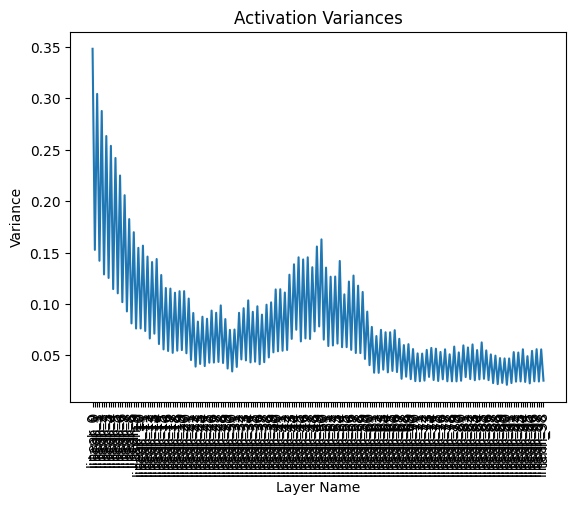

In [16]:
# on the fine-tuning dataset?
results, variances = compute_layer_variances(fashion_model, number_dataset.test_loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], variance_values[:-2])
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()

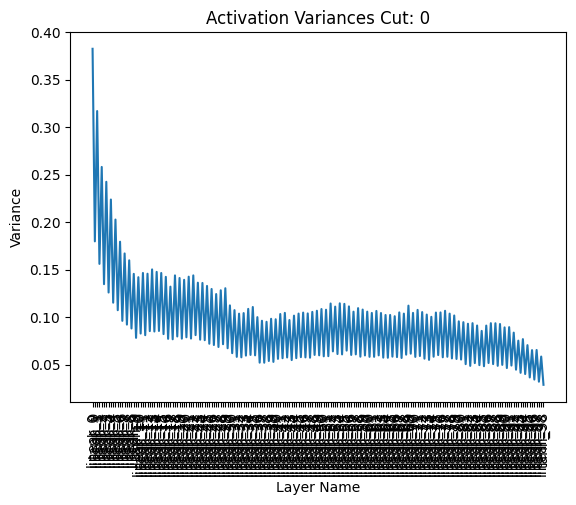

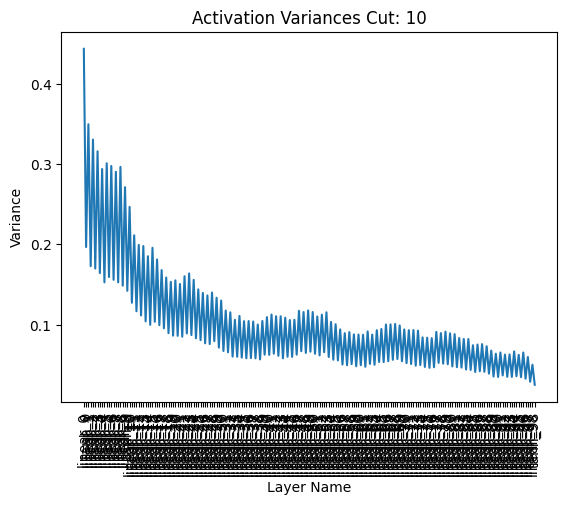

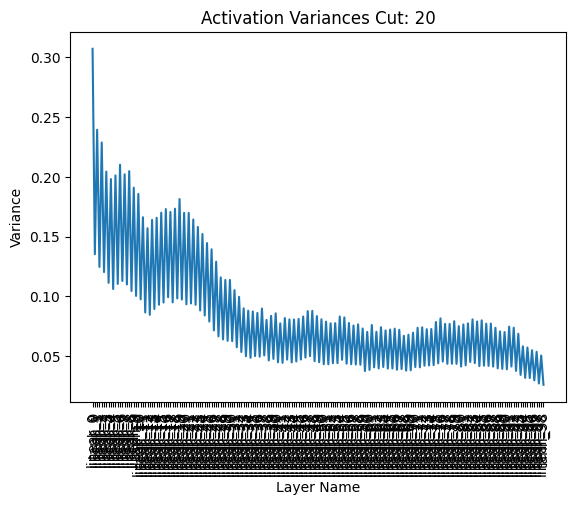

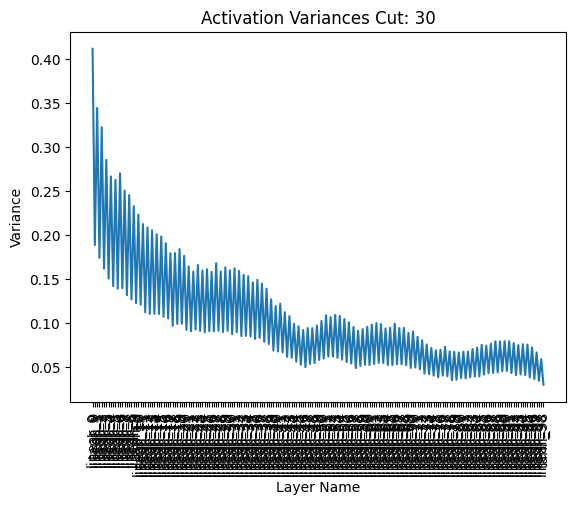

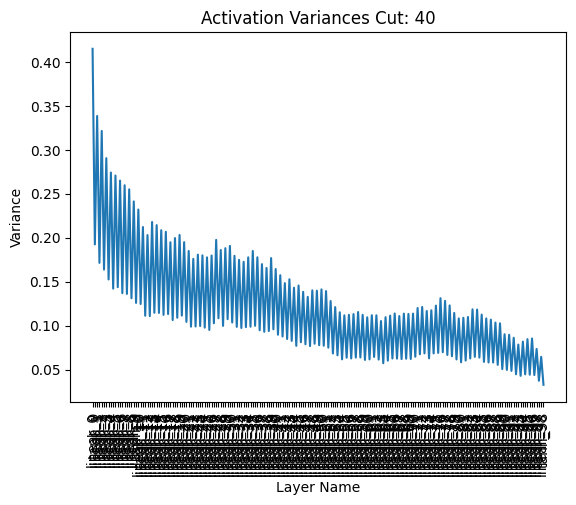

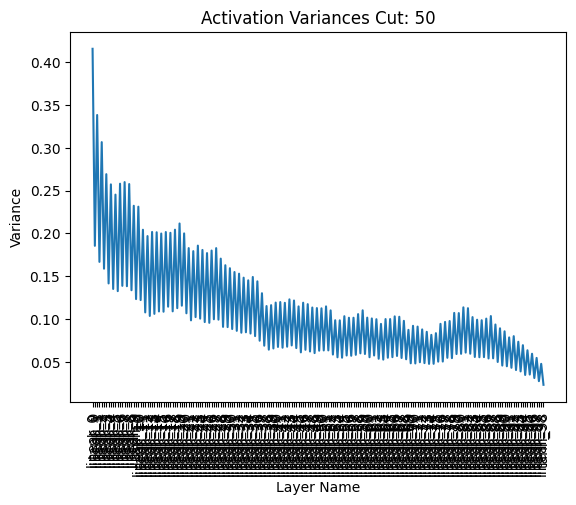

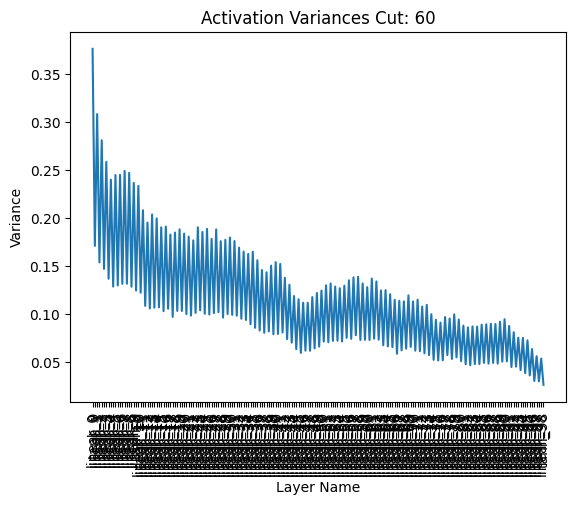

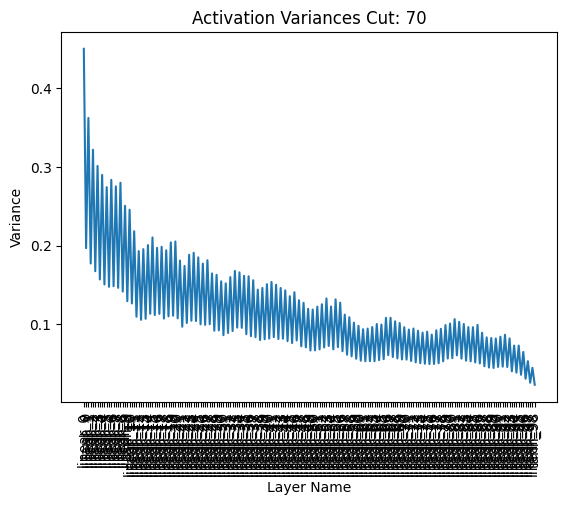

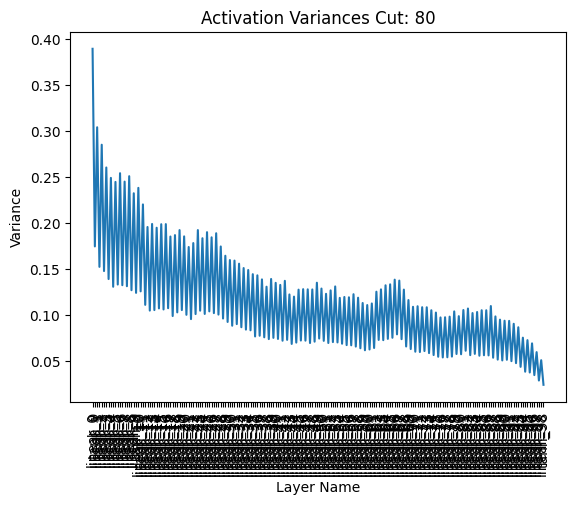

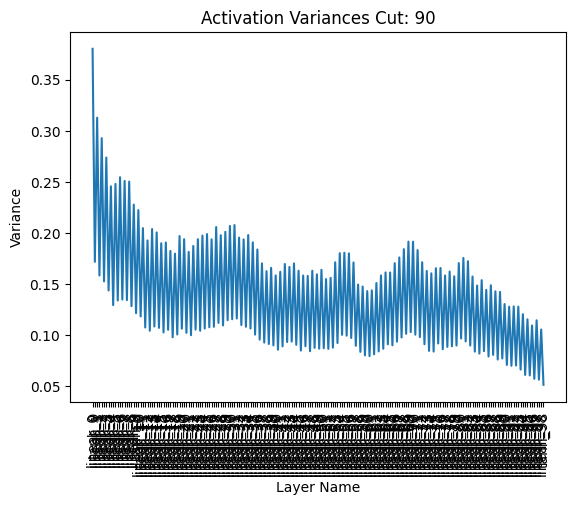

In [ ]:
for idx, mod in enumerate(cut_models):
    # Same for all fine-tuned:
    mod['cut_model'].eval()
    linear_layers = []
    activation_layers = []
    for i, layer in enumerate(mod['cut_model'].modules()):
      if i % 2 == 1:
        linear_layers.append(layer)
      else:
        activation_layers.append(layer)
    activation_layers = activation_layers[1:]
    results, variances = compute_layer_variances(mod['cut_model'], fashion_dataset.test_loader, device = 'cuda')
    # for layer_name, variance in results.items():
    #    print(f"Layer {layer_name} - Variance: {variance}")

    # Create a list of layer names and variances
    layer_names = list(variances.keys())
    variance_values = [variance.mean().item() for variance in variances.values()]

    # Plot the variances
    plt.plot(layer_names[:-2], variance_values[:-2])
    plt.xticks(rotation=90)
    plt.xlabel('Layer Name')
    plt.ylabel('Variance')
    plt.title('Activation Variances Cut: {}'.format(idx*10))
    plt.show()

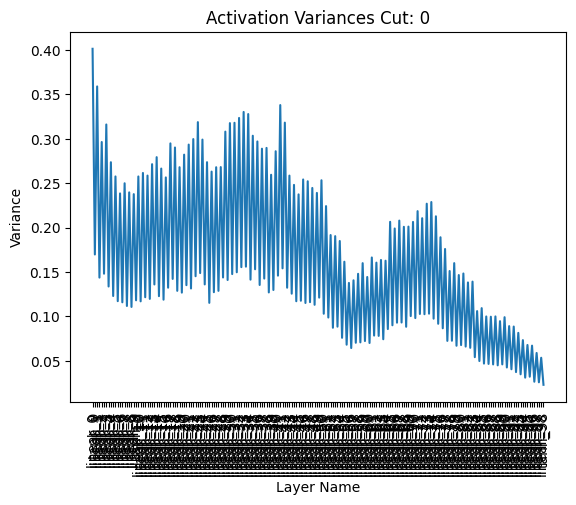

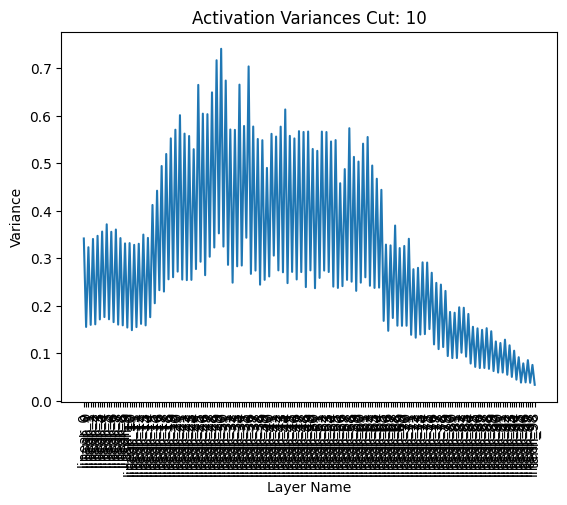

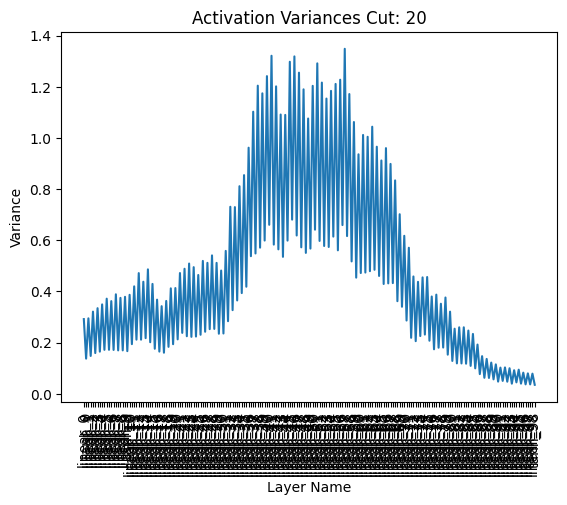

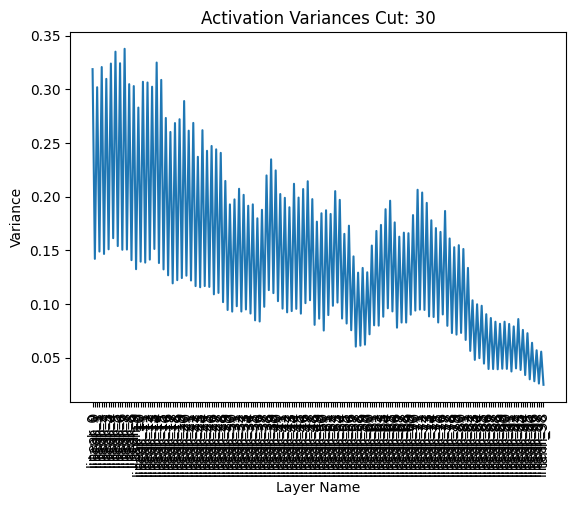

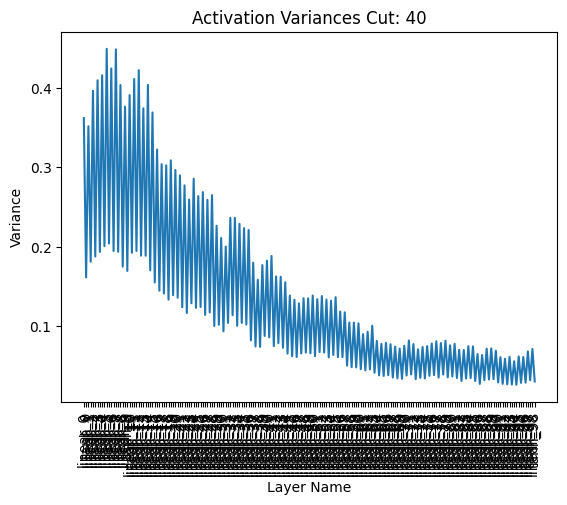

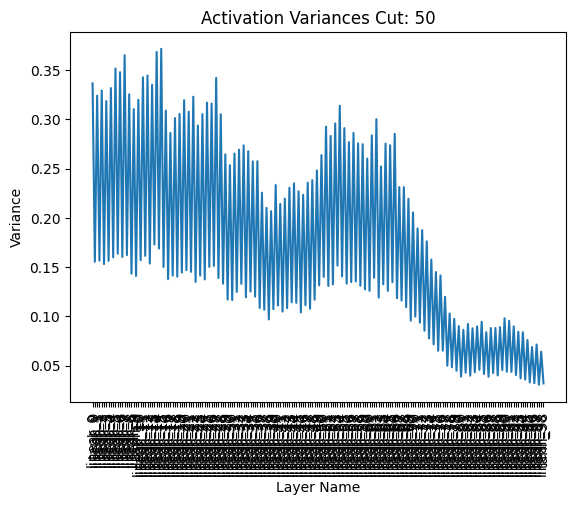

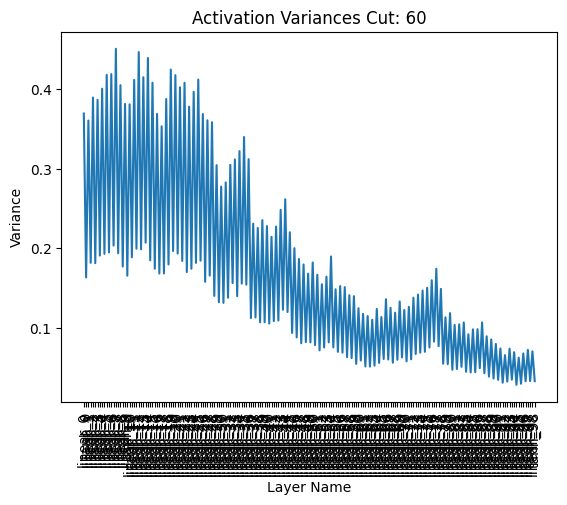

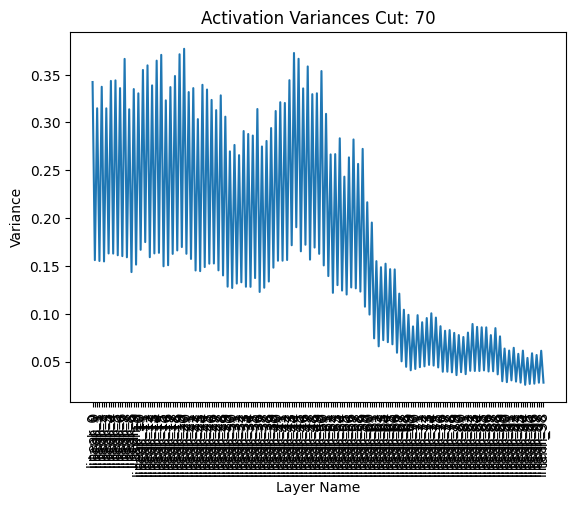

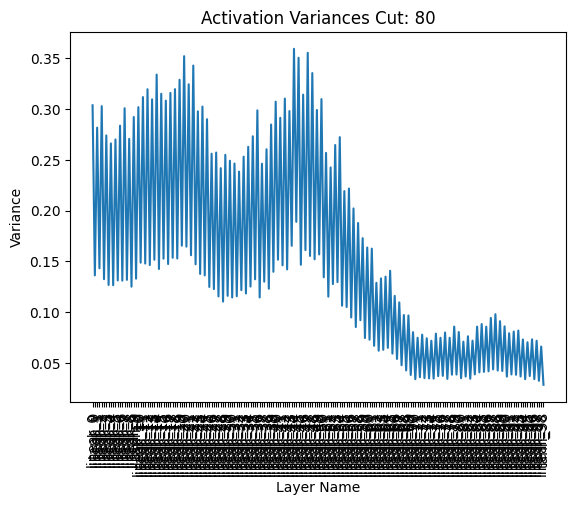

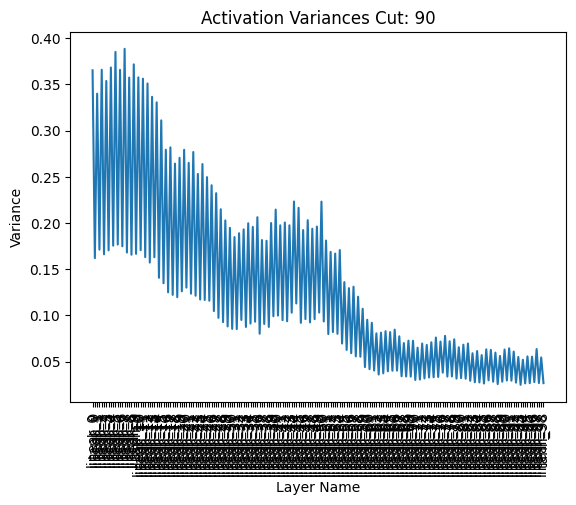

In [17]:
for idx, mod in enumerate(cut_models):
    # Same for all fine-tuned:
    mod['cut_model'].eval()
    linear_layers = []
    activation_layers = []
    for i, layer in enumerate(mod['cut_model'].modules()):
      if i % 2 == 1:
        linear_layers.append(layer)
      else:
        activation_layers.append(layer)
    activation_layers = activation_layers[1:]
    results, variances = compute_layer_variances(mod['cut_model'], number_dataset.test_loader, device = 'cuda')
    # for layer_name, variance in results.items():
    #    print(f"Layer {layer_name} - Variance: {variance}")

    # Create a list of layer names and variances
    layer_names = list(variances.keys())
    variance_values = [variance.mean().item() for variance in variances.values()]

    # Plot the variances
    plt.plot(layer_names[:-2], variance_values[:-2])
    plt.xticks(rotation=90)
    plt.xlabel('Layer Name')
    plt.ylabel('Variance')
    plt.title('Activation Variances Cut: {}'.format(idx*10))
    plt.show()